In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
# export
from exp.nb_04 import *
from matplotlib import pyplot as plt
import math
from torch import tensor

## Initial setup

In [3]:
x_train, y_train, x_valid, y_valid = get_data()

ds_train = Dataset(x_train, y_train)
ds_valid = Dataset(x_valid, y_valid)

File mnist.pkl.gz already exists in data


In [4]:
nh = 50
bs = 512
c = y_train.max().item() + 1

In [5]:
loss_func = F.cross_entropy

In [6]:
data = DataBunch(*get_dls(ds_train, ds_valid, bs),c)

In [7]:
# export
def create_learner(model_func, loss_func, data):
    return Learner(*model_func(data), loss_func, data)

In [8]:
learn = create_learner(get_model, loss_func, data)

acc_callback = AvgStatsCallback([accuracy])
runner = Runner([acc_callback])

runner.fit(3, learn)

train: [0.667104765625, tensor(0.8049)]
valid: [0.303549609375, tensor(0.9101)]
train: [0.29501767578125, tensor(0.9146)]
valid: [0.2355237060546875, tensor(0.9348)]
train: [0.2353675, tensor(0.9320)]
valid: [0.2103149169921875, tensor(0.9402)]


In [9]:
# export
def get_model_func(lr=0.5):
    return partial(get_model, lr=lr)

In [10]:
learn.opt.param_groups[-1].keys()

dict_keys(['params', 'lr', 'momentum', 'dampening', 'weight_decay', 'nesterov'])

In [11]:
learn.opt.param_groups[-1]['lr']

0.5

In [12]:
runner.loss

tensor(0.1967)

In [13]:
# export
class Recorder(Callback):
    def begin_fit(self):
        self.lrs = []
        self.losses = []
    
    def after_batch(self):
        if not self.in_train:
            return
        self.lrs.append(self.opt.param_groups[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())
    
    def plot_lrs(self):
        plt.plot(self.lrs)
    
    def plot_losses(self):
        plt.plot(self.losses)

In [14]:
# export
class ParamScheduler(Callback):
    _order = 1
    
    def __init__(self, pname, sched_func):
        self.pname = pname
        self.sched_func = sched_func
    
    def set_param(self):
        for param_group in self.opt.param_groups:
            param_group[self.pname] = self.sched_func(self.n_epochs/self.epochs)
    
    def begin_batch(self):
        if self.in_train:
            self.set_param()

In [15]:
def sched_linear(start, end):
    def _inner(pos):
        return start + pos * (end-start)
    return _inner

In [16]:
sched_linear(0,10)(0.5)

5.0

In [17]:
# export
from functools import partial

def annealer(f):
    def _inner(start, end):
        return partial(f, start, end)
    return _inner

In [18]:
def sched_linear(start, end, pos):
    return start + pos * (end-start) 

In [19]:
annealer(sched_linear)(0, 10)

functools.partial(<function sched_linear at 0x7f8917be4488>, 0, 10)

In [20]:
# export
@annealer
def sched_linear(start, end, pos):
    return start + pos * (end-start) 

In [21]:
f = sched_linear(0,10)
f(0.5), f

(5.0, functools.partial(<function sched_linear at 0x7f8917be49d8>, 0, 10))

In [22]:
# export
@annealer
def sched_cos(start, end, pos):
    return start + (1 + math.cos(math.pi*(1-pos))) * (end-start)/2

@annealer
def sched_no(start, end, pos):
    return start

@annealer
def sched_exp(start, end, pos):
    return start * (end/start) ** pos

In [23]:
# export
# Monkey patch
torch.Tensor.ndim = property(lambda x: len(x.shape))

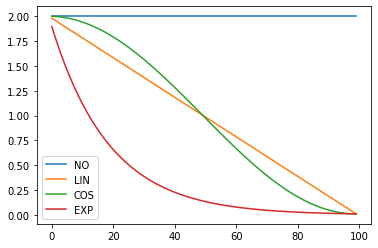

In [24]:
labels = "NO LIN COS EXP".split()
fns = [sched_no, sched_linear, sched_cos, sched_exp]

a = torch.arange(100)
p = torch.linspace(.01, 1, 100)


for fn, l in zip(fns, labels):
    f = fn(2, 1e-2)
    plt.plot(a, [f(o) for o in p], label=l)

plt.legend();

In [25]:
# export
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1
    assert len(pcts) == len(scheds)
    pcts = tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        sched_pos = (pos - pcts[idx]) / (pcts[idx+1] - pcts[idx])
        return scheds[idx](sched_pos)
    return _inner

In [26]:
sched = combine_scheds([.3, .7], [sched_cos(.3,.6), sched_cos(.6,.2)])

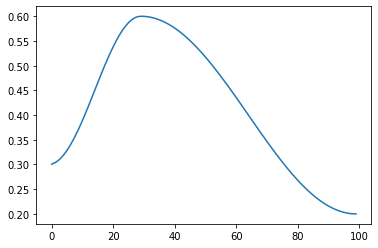

In [27]:
plt.plot(a, [sched(o) for o in p]);

In [28]:
cbfs = [Recorder, 
        partial(AvgStatsCallback, accuracy), 
        partial(ParamScheduler, 'lr', sched)]

In [29]:
learn = create_learner(get_model_func(.3), loss_func, data)
run = Runner(cb_funcs=cbfs)

In [30]:
run.fit(5, learn)

train: [0.775810390625, tensor(0.7980)]
valid: [0.3330916748046875, tensor(0.9014)]
train: [0.3375978125, tensor(0.8986)]
valid: [0.247367822265625, tensor(0.9270)]
train: [0.24115244140625, tensor(0.9299)]
valid: [0.2017288330078125, tensor(0.9436)]
train: [0.20312677734375, tensor(0.9409)]
valid: [0.1808017822265625, tensor(0.9489)]
train: [0.18383076171875, tensor(0.9465)]
valid: [0.17153568115234374, tensor(0.9538)]


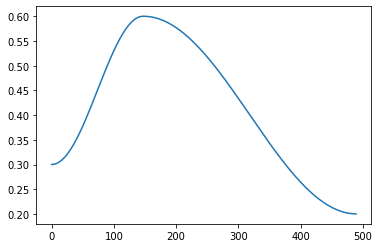

In [31]:
run.recorder.plot_lrs()

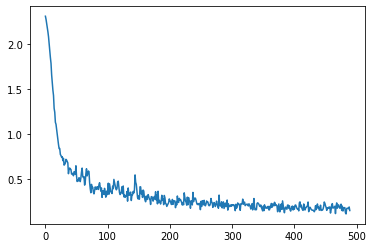

In [32]:
run.recorder.plot_losses()